# Numba usage stats

Jim Pivarski

## How the data were collected

<br>

**Step 1:** Scrape the [dependents graph for numba/numba on GitHub](https://github.com/numba/numba/network/dependents) (the repositories, not the packages).

Web-scraping script in [step1.py](step1.py).

When I did it, there were 62903 of these.

<br><br><br>

**Step 2:** For each of those repos, [get the repo metadata using the GitHub API](https://docs.github.com/en/rest/repos/repos?apiVersion=2022-11-28#get-a-repository), taking care to not exceed the [rate limit](https://docs.github.com/en/rest/rate-limit/rate-limit?apiVersion=2022-11-28).

My list has 62900 of these. (I guess 3 were lost.)

My copy of the repo info can be found in [https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-REPO-INFO.tgz](https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-REPO-INFO.tgz) (32.1 MB).

My copy of the [user info, also from GitHub API](https://docs.github.com/en/rest/users/users?apiVersion=2022-11-28) (for bios) can be found in [https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-USER-INFO.tgz](https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-USER-INFO.tgz) (2.0 MB).

<br><br><br>

**Step 3:** For the repos in which `"fork": false` (users created the repo themselves), download all of the repos.

59233 repos from my previous list are non-fork.

I have the final results on a 380 GB disk, but I think I used a 1 TB disk during the process (all on AWS).

The [step3.py](step3.py) script performs the giant `git clone` of all these repos. It's a parallized pipeline (`ProcessPoolExecutor` with `max_workers=24` on a computer with 4 CPU cores... it's I/O limited) with the following steps:

1. `git clone` with `--depth 1` to get the latest snapshot, but not the history.
2. Do a `grep -i` for `\bnumba\b` to cross-check GitHub's identification of these as depending on Numba and keep the result in a `*.grep` file beside the final tarball.
3. Drop any files that are greater than 1 MB (some GitHub repos contain large data files) if they _do not_ have an interesting file suffix: `py`, `PY`, `ipynb`, `IPYNB`, `c`, `cc`, `cpp`, `cp`, `cxx`, `c++`, `C`, `CC`, `CPP`, `CP`, `CXX`, `C++`, `h`, `hpp`, `hp`, `hh`, `H`, `HPP`, `HP`, `HH`, `cu`, `cuh`, `CU`, `CUH`.
4. Tarball-and-compress what remains.

Occasionally, one of the 24 workers would get stuck with a large download, but the others moved past it. In the end, I think there were only a couple that couldn't be downloaded after a few attempts. (The script does not re-download, so it can be used to clean up after failed attempts.)

<br><br><br>

**Step 4:** Further select only the repos that actually contain

```regex
\b(import\s+([A-Za-z_][A-Za-z_0-9]*\s*,\s*)*numba|from\s+numba\s+import)\b
```

in some file. After this selection, only 13512 repos were kept (22.8%). Some of the repos that GitHub identified mentioned Numba in text or used it in markdown examples, but didn't import it: GitHub's interpretation of a "dependent repo" is very broad.

Finally, tarball (without compression!) the directory full of gzipped tarballs. My copy is at [https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-raw-data-1Mcut-imports.tar](https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-raw-data-1Mcut-imports.tar) (179.4 GB).

<br><br><br>

**Step 5:** Do a static code analysis on all of the Python and Jupyter notebook files. This is another `ProcessPoolExecutor` pipeline, which results in a JSON file that will be used in interactive analysis. The steps of the pipeline are:

1. Identify programming language by file extension, to learn which programming languages are used _alongside_ Numba.
2. For all C/C++/CUDA files,
  * try to parse it as a pure C file using [pycparser](https://github.com/eliben/pycparser) (mostly to distinguish between C and C++),
  * look for [CUDA's triple angle brackets](https://stackoverflow.com/q/77689913/1623645), and
  * regex-search it for `\s*#include [<\"](.*)[>\"]` to get a list of includes (and identify if the include-file name matches the name of a file in the repo, so that locally defined files can be excluded).
3. For all Python and Jupyter notebook files, parse the file with Python 3 (3.10.12) and indicate if parsing failed. For Jupyter, use [jupytext](https://github.com/mwouts/jupytext) to transform the Jupyter JSON into an in-memory pure Python, with IPython magics removed. Then, walk the Python AST to
  * collect all information on top-level imports and nested imports, keeping track of how imported modules or symbols are renamed,
  * if any of these are under the `numba` module, collect all symbol references and argument lists of function calls, including whether or not a function was used as a decorator, and
  * pay close attention to JIT-compilation functions/decorators: `numba.jit`, `numba.njit`, `numba.generated_jit`, `numba.vectorize`, `numba.guvectorize`, `numba.cfunc`.

My copy of the static analysis results is at [https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-static-analysis-results.jsons.gz](https://pivarski-princeton.s3.amazonaws.com/GitHub-numba-user-nonfork-static-analysis-results.jsons.gz) (77.0 MB).

<br><br><br>

## Analysis

<br>

In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
results = []
with open("static-analysis-results.jsons") as file:
    for line in file:
        results.append(json.loads(line))

In [3]:
len(results)

13511

In [4]:
df = pd.DataFrame([{"suffix": cfile["suffix"], "is_c": cfile["data"]["is_c"], "is_cuda": cfile["data"]["num_cuda"] > 0} for result in results for cfile in result["c"]])
df

,suffix,is_c,is_cuda
0,cpp,True,False
1,c,False,False
2,c,False,False
3,cpp,False,False
4,cpp,False,False
...,...,...,...
897086,h,False,False
897087,h,False,False
897088,h,False,False
897089,h,False,False


The file extension is useless for determining if something is pure C versus C++.

In [5]:
df["suffix"][df["is_c"]].value_counts()

suffix
h      9157
cpp    3236
c      3024
hpp    2311
cxx     160
cc      106
cuh      49
cu       20
hh        6
hxx       5
Name: count, dtype: int64

In [6]:
df["suffix"][~df["is_c"]].value_counts()

suffix
h      401378
cpp    194933
c       85414
cc      73949
hpp     45596
cu      40778
cxx     24752
cuh      6170
hh       3046
hxx      2982
c++        13
cp          3
hp          3
Name: count, dtype: int64

But it's a pretty good indicator that a CUDA file is a CUDA file (unless it's a header file, but then my method of checking for `<<<` `>>>` doesn't work, either).

In [7]:
df["suffix"][df["is_cuda"]].value_counts()

suffix
cu     18197
h       1274
cuh      962
c        101
cpp       85
hpp       82
cc        73
hxx        2
hh         1
Name: count, dtype: int64

In [8]:
df["suffix"][~df["is_cuda"]].value_counts()

suffix
h      409261
cpp    198084
c       88337
cc      73982
hpp     47825
cxx     24912
cu      22601
cuh      5257
hh       3051
hxx      2985
c++        13
cp          3
hp          3
Name: count, dtype: int64

In [9]:
languages = []
for result in results:
    for pyfile in result["python"]:
        if pyfile["data"] is not None and any(x == "numba" or x.startswith("numba.") for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"])):
            break
    else:
        continue
    username, reponame = result["name"].split("/", 1)
    languages.append({"user": username, "repo": reponame})
    for cfile in result["c"]:
        if cfile["data"]["num_cuda"] > 0 or cfile["suffix"] in ("cu", "cuh"):
            languages[-1]["CUDA"] = True
        elif cfile["data"]["is_c"]:
            languages[-1]["C"] = True
        else:
            languages[-1]["C++"] = True
    for k, v in result["other_language"].items():
        if v > 0:
            languages[-1][k] = True

df = pd.DataFrame(languages).fillna(False)
df

/tmp/ipykernel_76275/2710413475.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(languages).fillna(False)


,user,repo,C,C++,Cython,Julia,Swift,Go,CUDA,Java,...,R,Rust,MATLAB,Fortran,Groovy,Scala,Kotlin,F#,Haskell,Ada
0,JeffreyMinucci,ht_occupational,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,dreamento,dreamento,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,nitin7478,Backorder_Prediction,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,exafmm,pyexafmm,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,astro-informatics,sleplet,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13087,haowen-xu,tensorkit,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13088,WONDER-project,OASYS1-WONDER,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13089,WONDER-project,Orange3-WONDER,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13090,maciej-sypetkowski,autoascend,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
len(df) / len(results)

0.9689882318111168

In the following, "C++" and "C" are mutually exclusive categories of file ("does it compile in pycparser or not?"), but the bars are not mutually exclusive because a repo can contain a C++ file _and also_ a pure C file.

"CUDA" is not exclusive with respect to "C++" and "C"; it corresponds to any C-like file with `<<<` `>>>` in it.

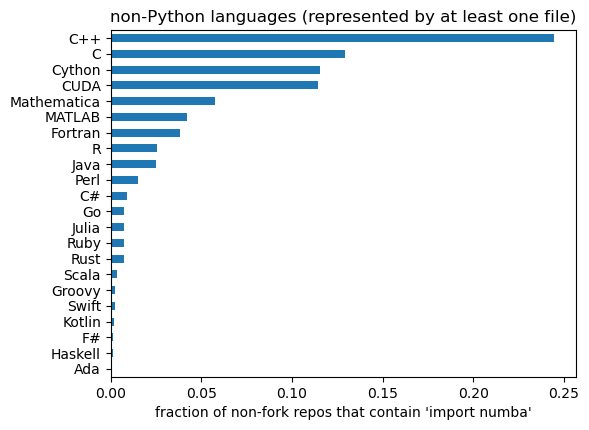

In [11]:
fig, ax = plt.subplots(figsize=(6, 4.5))

(df.drop(columns=["user", "repo"]).sum(axis=0).sort_values() / len(df)).plot.barh(ax=ax)
ax.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax.set_title("non-Python languages (represented by at least one file)")

None

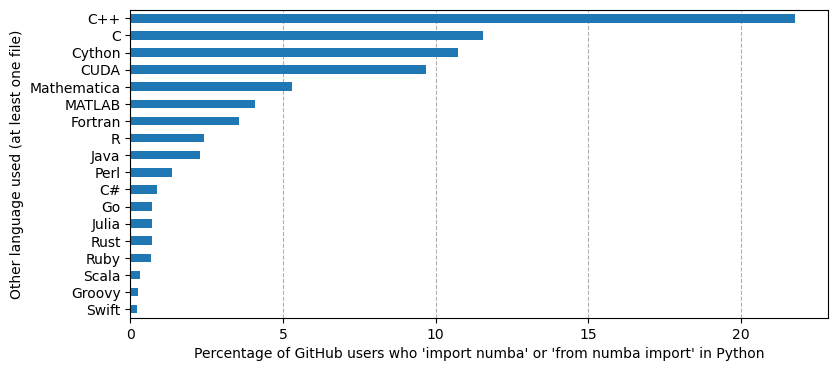

In [12]:
fig, ax = plt.subplots(figsize=(9, 4))

(df.drop(columns=["repo"]).groupby("user").any().sum(axis=0).sort_values()[4:] * 100 / len(df)).plot.barh(ax=ax)
ax.set_xlabel("Percentage of GitHub users who 'import numba' or 'from numba import' in Python")
ax.set_ylabel("Other language used (at least one file)")
ax.xaxis.grid(linestyle="--")
ax.set_axisbelow(True)

# fig.savefig("numba-users-other-language.svg")
# fig.savefig("numba-users-other-language.pdf")

In [13]:
df.drop(columns=["repo"]).groupby("user").any().sum(axis=0).sort_values()

Ada               1
Haskell          13
F#               14
Kotlin           24
Swift            29
Groovy           32
Scala            43
Ruby             90
Rust             91
Julia            92
Go               93
C#              115
Perl            177
Java            300
R               317
Fortran         465
MATLAB          533
Mathematica     692
CUDA           1270
Cython         1406
C              1511
C++            2850
dtype: int64

In [14]:
STDLIB_MODULES = {
    "__main__",
    "string",
    "re",
    "difflib",
    "textwrap",
    "unicodedata",
    "stringprep",
    "readline",
    "rlcompleter",
    "struct",
    "codecs",
    "datetime",
    "calendar",
    "collections",
    "heapq",
    "bisect",
    "array",
    "weakref",
    "types",
    "copy",
    "pprint",
    "reprlib",
    "enum",
    "numbers",
    "math",
    "cmath",
    "decimal",
    "fractions",
    "random",
    "statistics",
    "itertools",
    "functools",
    "operator",
    "pathlib",
    "fileinput",
    "stat",
    "filecmp",
    "tempfile",
    "glob",
    "fnmatch",
    "linecache",
    "shutil",
    "macpath",
    "pickle",
    "copyreg",
    "shelve",
    "marshal",
    "dbm",
    "sqlite3",
    "zlib",
    "gzip",
    "bz2",
    "lzma",
    "zipfile",
    "tarfile",
    "csv",
    "configparser",
    "netrc",
    "xdrlib",
    "plistlib",
    "hashlib",
    "hmac",
    "secrets",
    "os",
    "io",
    "time",
    "argparse",
    "getopt",
    "logging",
    "getpass",
    "curses",
    "platform",
    "errno",
    "ctypes",
    "threading",
    "multiprocessing",
    "concurrent",
    "subprocess",
    "sched",
    "queue",
    "_thread",
    "_dummy_thread",
    "dummy_threading",
    "contextvars",
    "asyncio",
    "socket",
    "ssl",
    "select",
    "selectors",
    "asyncore",
    "asynchat",
    "signal",
    "mmap",
    "email",
    "json",
    "mailcap",
    "mailbox",
    "mimetypes",
    "base64",
    "binhex",
    "binascii",
    "quopri",
    "uu",
    "html",
    "xml",
    "webbrowser",
    "cgi",
    "cgitb",
    "wsgiref",
    "urllib",
    "ftplib",
    "poplib",
    "imaplib",
    "nntplib",
    "smtplib",
    "smtpd",
    "telnetlib",
    "uuid",
    "socketserver",
    "xmlrpc",
    "ipaddress",
    "audioop",
    "aifc",
    "sunau",
    "wave",
    "chunk",
    "colorsys",
    "imghdr",
    "sndhdr",
    "ossaudiodev",
    "gettext",
    "locale",
    "turtle",
    "cmd",
    "shlex",
    "tkinter",
    "typing",
    "pydoc",
    "doctest",
    "unittest",
    "lib2to3",
    "test",
    "bdb",
    "faulthandler",
    "pdb",
    "timeit",
    "trace",
    "tracemalloc",
    "distutils",
    "ensurepip",
    "venv",
    "zipapp",
    "sys",
    "sysconfig",
    "builtins",
    "warnings",
    "dataclasses",
    "contextlib",
    "abc",
    "atexit",
    "traceback",
    "__future__",
    "gc",
    "inspect",
    "site",
    "code",
    "codeop",
    "zipimport",
    "pkgutil",
    "modulefinder",
    "runpy",
    "importlib",
    "parser",
    "ast",
    "symtable",
    "symbol",
    "token",
    "keyword",
    "tokenize",
    "tabnanny",
    "pyclbr",
    "py_compile",
    "compileall",
    "dis",
    "pickletools",
    "formatter",
    "msilib",
    "msvcrt",
    "winreg",
    "winsound",
    "posix",
    "pwd",
    "spwd",
    "grp",
    "crypt",
    "termios",
    "tty",
    "pty",
    "fcntl",
    "pipes",
    "resource",
    "nis",
    "syslog",
    "optparse",
    "imp",
    "posixpath",
    "ntpath",
}

In [15]:
# https://stackoverflow.com/a/2029106/1623645

C_STDLIB_MODULES = set([
    "aio.h",
    "algorithm",
    "any",
    "arpa/inet.h",
    "array",
    "assert.h",
    "atomic",
    "barrier",
    "bit",
    "bitset",
    "cassert",
    "ccomplex",
    "cctype",
    "cerrno",
    "cfenv",
    "cfloat",
    "charconv",
    "chrono",
    "cinttypes",
    "ciso646",
    "climits",
    "clocale",
    "cmath",
    "codecvt",
    "compare",
    "complex",
    "complex.h",
    "concepts",
    "condition_variable",
    "coroutine",
    "cpio.h",
    "csetjmp",
    "csignal",
    "cstdalign",
    "cstdarg",
    "cstdbool",
    "cstddef",
    "cstdint",
    "cstdio",
    "cstdlib",
    "cstring",
    "ctgmath",
    "ctime",
    "ctype.h",
    "cuchar",
    "curses.h",
    "cwchar",
    "cwctype",
    "deque",
    "dirent.h",
    "dlfcn.h",
    "errno.h",
    "exception",
    "execution",
    "expected",
    "fcntl.h",
    "fenv.h",
    "filesystem",
    "flat_map",
    "flat_set",
    "float.h",
    "fmtmsg.h",
    "fnmatch.h",
    "format",
    "forward_list",
    "fstream",
    "ftw.h",
    "functional",
    "future",
    "generator",
    "glob.h",
    "grp.h",
    "iconv.h",
    "initializer_list",
    "inttypes.h",
    "iomanip",
    "ios",
    "iosfwd",
    "iostream",
    "iso646.h",
    "istream",
    "iterator",
    "langinfo.h",
    "latch",
    "libgen.h",
    "limits",
    "limits.h",
    "list",
    "locale",
    "locale.h",
    "map",
    "math.h",
    "mdspan",
    "memory",
    "memory_resource",
    "monetary.h",
    "mqueue.h",
    "mutex",
    "ndbm.h",
    "netdb.h",
    "net/if.h",
    "netinet/in.h",
    "netinet/tcp.h",
    "new",
    "nl_types.h",
    "numbers",
    "numeric",
    "optional",
    "ostream",
    "poll.h",
    "print",
    "pthread.h",
    "pwd.h",
    "queue",
    "random",
    "ranges",
    "ratio",
    "regex",
    "regex.h",
    "sched.h",
    "scoped_allocator",
    "search.h",
    "semaphore",
    "semaphore.h",
    "set",
    "setjmp.h",
    "shared_mutex",
    "signal.h",
    "source_location",
    "span",
    "spanstream",
    "spawn.h",
    "sstream",
    "stack",
    "stacktrace",
    "stdalign.h",
    "stdarg.h",
    "stdatomic.h",
    "stdbit.h",
    "stdbool.h",
    "stdckdint.h",
    "stddef.h",
    "stdexcept",
    "stdfloat",
    "stdint.h",
    "stdio.h",
    "stdlib.h",
    "stdnoreturn.h",
    "stop_token",
    "streambuf",
    "string",
    "string.h",
    "strings.h",
    "string_view",
    "stropts.h",
    "strstream",
    "syncstream",
    "sys/ipc.h",
    "syslog.h",
    "sys/mman.h",
    "sys/msg.h",
    "sys/resource.h",
    "sys/select.h",
    "sys/sem.h",
    "sys/shm.h",
    "sys/socket.h",
    "sys/stat.h",
    "sys/statvfs.h",
    "system_error",
    "sys/time.h",
    "sys/times.h",
    "sys/types.h",
    "sys/uio.h",
    "sys/un.h",
    "sys/utsname.h",
    "sys/wait.h",
    "tar.h",
    "term.h",
    "termios.h",
    "tgmath.h",
    "thread",
    "threads.h",
    "time.h",
    "trace.h",
    "tuple",
    "typeindex",
    "typeinfo",
    "type_traits",
    "uchar.h",
    "ulimit.h",
    "uncntrl.h",
    "unistd.h",
    "unordered_map",
    "unordered_set",
    "utility",
    "utime.h",
    "utmpx.h",
    "valarray",
    "variant",
    "vector",
    "version",
    "wchar.h",
    "wctype.h",
    "wordexp.h",
])

In [16]:
num_with_numba = 0
python_imports = Counter()
c_imports = Counter()
for result in results:
    for pyfile in result["python"]:
        if pyfile["data"] is not None and any(x == "numba" or x.startswith("numba.") for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"])):
            break
    else:
        continue
    num_with_numba += 1

    counter = Counter()
    for pyfile in result["python"]:
        if pyfile["data"] is not None:
            for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"]):
                if x not in STDLIB_MODULES and x != "numba":
                    counter[x] += 1
    for x in counter:
        python_imports[x] += 1

    counter = Counter()
    for cfile in result["c"]:
        if cfile["data"] is not None:
            for x in list(cfile["data"]["global"]) + list(cfile["data"]["local"]):
                if x not in C_STDLIB_MODULES and x != "numba":
                    counter[x] += 1
    for x in counter:
        c_imports[x] += 1

python_imports = sorted(python_imports.items(), key=lambda x: -x[1])
c_imports = sorted(c_imports.items(), key=lambda x: -x[1])

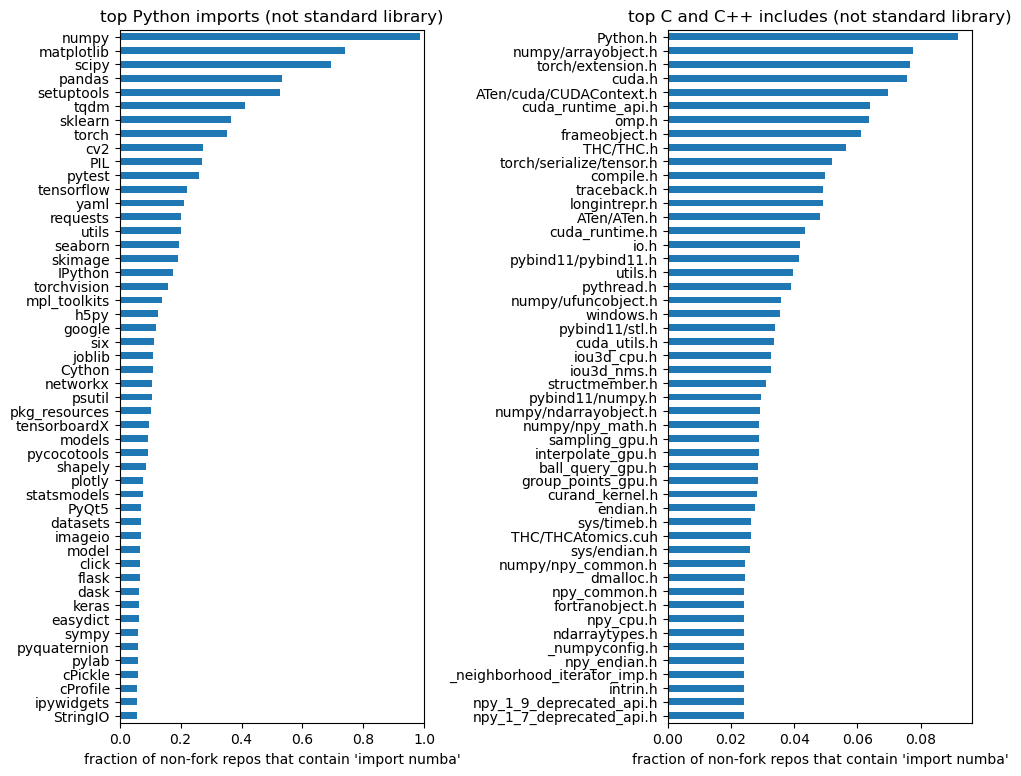

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 9))

(pd.Series(dict(python_imports[:50])).sort_values() / num_with_numba).plot.barh(ax=ax1)
ax1.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax1.set_title("top Python imports (not standard library)")
ax1.set_xlim(0, 1)

(pd.Series(dict(c_imports[:50])).sort_values() / num_with_numba).plot.barh(ax=ax2)
ax2.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax2.set_title("top C and C++ includes (not standard library)")
# ax2.set_xlim(0, 1)

plt.subplots_adjust(wspace=0.8)

None

In [18]:
num_with_numba = 0
numba_references = Counter()
for result in results:
    for pyfile in result["python"]:
        if pyfile["data"] is not None and any(x == "numba" or x.startswith("numba.") for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"])):
            break
    else:
        continue
    num_with_numba += 1

    counter = Counter()
    for pyfile in result["python"]:
        if pyfile["data"] is not None:
            for x in pyfile["data"]["numba"]:
                y = x.lstrip("@").split("(")[0]
                if x.startswith("numba.jit") and "nopython=True" in x:
                    y = "numba.njit"
                counter[y] += 1

    for x in counter:
        numba_references[x] += 1

numba_references = sorted(numba_references.items(), key=lambda x: -x[1])

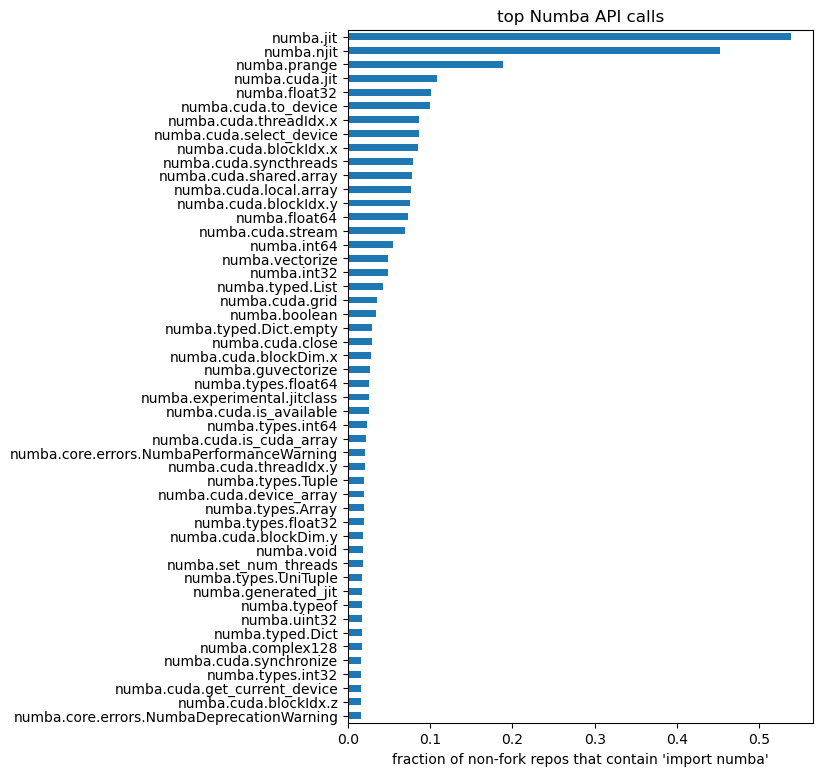

In [19]:
fig, ax = plt.subplots(figsize=(6, 9))

(pd.Series(dict(numba_references[:50])).sort_values() / num_with_numba).plot.barh(ax=ax)
ax.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax.set_title("top Numba API calls")
# ax1.set_xlim(0, 1)

None

In [20]:
JIT_FUNCTIONS = {"numba.jit", "numba.njit", "numba.generated_jit", "numba.vectorize", "numba.guvectorize", "numba.cfunc", "numba.cuda.jit"}

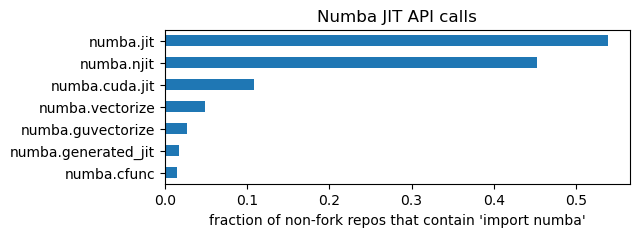

In [21]:
fig, ax = plt.subplots(figsize=(6, 2))

(pd.Series({k: v for k, v in numba_references if k in JIT_FUNCTIONS}).sort_values() / num_with_numba).plot.barh(ax=ax)
ax.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax.set_title("Numba JIT API calls")
# ax1.set_xlim(0, 1)

None

In [22]:
num_with_numba = 0
jit_arguments = Counter()
for result in results:
    for pyfile in result["python"]:
        if pyfile["data"] is not None and any(x == "numba" or x.startswith("numba.") for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"])):
            break
    else:
        continue
    num_with_numba += 1

    counter = Counter()
    for pyfile in result["python"]:
        if pyfile["data"] is not None:
            for x in pyfile["data"]["numba"]:
                if "(" in x and (x.lstrip("@").startswith("numba.jit") or x.lstrip("@").startswith("numba.njit")):
                    for arg in x.split("(", 1)[1].rstrip(")").split(","):
                        if "=" in arg:
                            counter[arg.strip()] += 1
                if x.lstrip("@").startswith("numba.njit"):
                    counter["nopython=True"] += 1

    for x in counter:
        jit_arguments[x] += 1

jit_arguments = sorted(jit_arguments.items(), key=lambda x: -x[1])

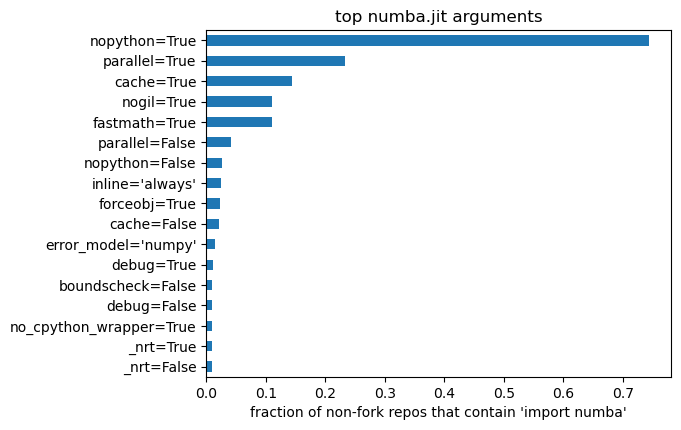

In [23]:
fig, ax = plt.subplots(figsize=(6, 4.5))

(pd.Series(dict(jit_arguments[:17])).sort_values() / num_with_numba).plot.barh(ax=ax)
ax.set_xlabel("fraction of non-fork repos that contain 'import numba'")
ax.set_title("top numba.jit arguments")
# ax1.set_xlim(0, 1)

None

In [24]:
num_with_numba = 0
num_with_numba_cuda = 0
for result in results:
    for pyfile in result["python"]:
        if pyfile["data"] is not None and any(x == "numba" or x.startswith("numba.") for x in list(pyfile["data"]["top"]) + list(pyfile["data"]["nested"])):
            break
    else:
        continue
    num_with_numba += 1

    any_cuda = False
    for pyfile in result["python"]:
        if pyfile["data"] is not None:
            for x in pyfile["data"]["numba"]:
                if x.startswith("numba.cuda"):
                    any_cuda = True

    if any_cuda:
        num_with_numba_cuda += 1

num_with_numba_cuda / num_with_numba

0.13978001833180567